# 1. Import libraries

In [1]:
import tensorflow as tf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17190021410173426919
xla_global_id: -1
]


''

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

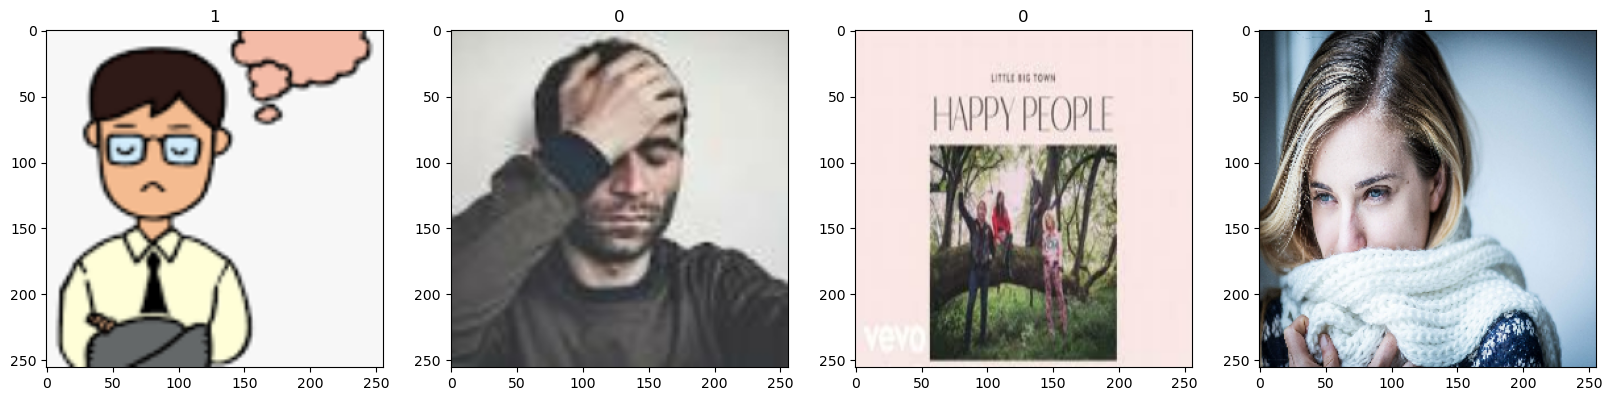

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[4.91207093e-01, 5.14736533e-01, 4.68351722e-01],
          [5.07015944e-01, 5.30545354e-01, 4.91329670e-01],
          [5.29993892e-01, 5.56893408e-01, 5.15992641e-01],
          ...,
          [7.97212005e-01, 8.52113962e-01, 8.52113962e-01],
          [7.80514717e-01, 8.35416675e-01, 8.35416675e-01],
          [7.65716910e-01, 8.20618868e-01, 8.20618868e-01]],
 
         [[4.91207093e-01, 5.14736533e-01, 4.68351722e-01],
          [5.07015944e-01, 5.30545354e-01, 4.91329670e-01],
          [5.29993892e-01, 5.56893408e-01, 5.15992641e-01],
          ...,
          [7.98344135e-01, 8.53246093e-01, 8.53246093e-01],
          [7.80514717e-01, 8.35416675e-01, 8.35416675e-01],
          [7.68125296e-01, 8.23027253e-01, 8.23027253e-01]],
 
         [[4.91207093e-01, 5.14736533e-01, 4.68351722e-01],
          [5.07015944e-01, 5.30545354e-01, 4.91329670e-01],
          [5.29993892e-01, 5.56893408e-01, 5.15992641e-01],
          ...,
          [7.98897088e-01, 8.53799045e-01, 8.5379

# 5. Split Data

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train_size

7

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
7/7 [==============================] - 6s 563ms/step - loss: 0.7833 - accuracy: 0.5625 - val_loss: 0.6032 - val_accuracy: 0.5938
Epoch 2/40
7/7 [==============================] - 4s 464ms/step - loss: 0.6109 - accuracy: 0.5848 - val_loss: 0.6177 - val_accuracy: 0.5312
Epoch 3/40
7/7 [==============================] - 4s 418ms/step - loss: 0.5706 - accuracy: 0.6786 - val_loss: 0.4863 - val_accuracy: 0.8125
Epoch 4/40
7/7 [==============================] - 4s 402ms/step - loss: 0.4893 - accuracy: 0.8036 - val_loss: 0.4155 - val_accuracy: 0.8438
Epoch 5/40
7/7 [==============================] - 4s 395ms/step - loss: 0.4470 - accuracy: 0.7946 - val_loss: 0.4032 - val_accuracy: 0.8281
Epoch 6/40
7/7 [==============================] - 4s 439ms/step - loss: 0.3550 - accuracy: 0.8750 - val_loss: 0.3521 - val_accuracy: 0.8594
Epoch 7/40
7/7 [==============================] - 4s 455ms/step - loss: 0.2819 - accuracy: 0.9062 - val_loss: 0.2006 - val_accuracy: 0.9375
Epoch 8/40
7/7 [====

# 8. Plot Performance

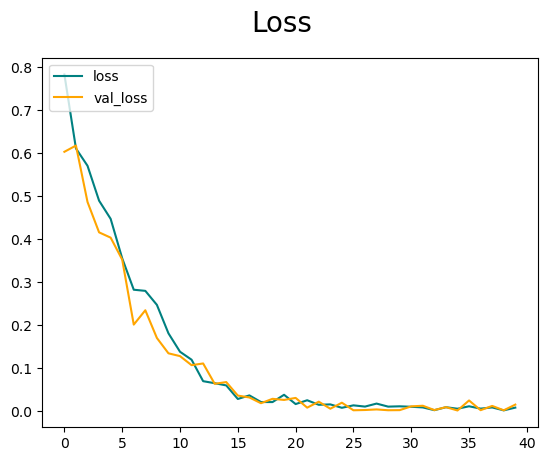

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

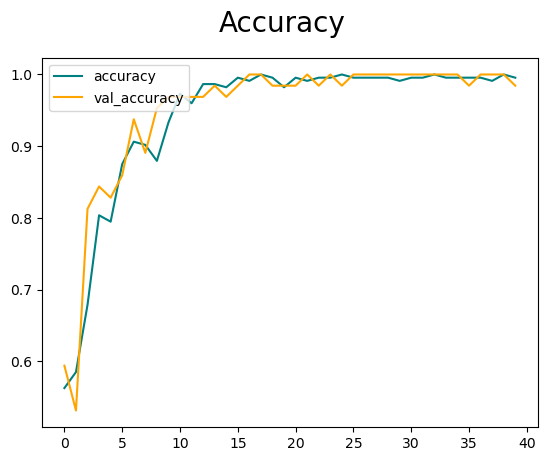

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 141ms/step


In [44]:
# print(pre.result()) 
# print(re.result()) 
# print(acc.result())

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [45]:
import cv2

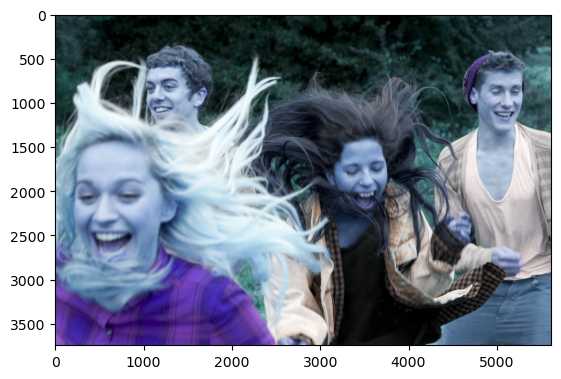

In [46]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

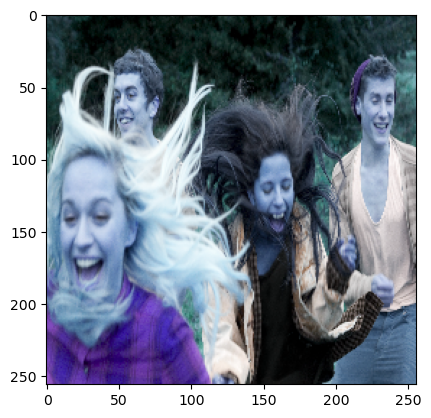

In [47]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 20ms/step


In [49]:
yhat

array([[0.9093648]], dtype=float32)

In [50]:
if yhat > 0.5: 
    print(f'Predicted class is Happy')
else:
    print(f'Predicted class is Sad')

Predicted class is Happy


# 11. Save the Model

In [51]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('models','imageclassifier.h5'))

In [53]:
new_model = load_model('models/imageclassifier.h5')

In [54]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 88ms/step


array([[0.9093648]], dtype=float32)